## Thumbail Generation Algorithm Demo

### Image Processing Steps
1. Load image into RGB matrix
2. Create a gray image from RGB image
3. Find product's bounding box from gray image
4. Classify that if the image is single product image (with white background) or scene image
5. Crop image or padding image based on image type condition
    a. If it is product image, crop or pad based on the bounding box
    b. If it is scene image, crop image to make it square

non white pixels percentage: 0.9482167352537723
It is a scene image


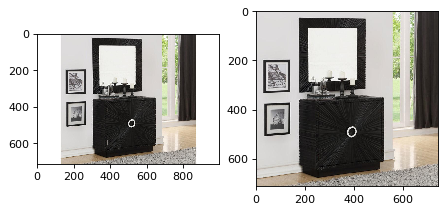

In [14]:
import cv2 
import os
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

def loadImage(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def resize(img, size = (100, 100)):
    img = cv2.resize(img, size, interpolation = cv2.INTER_AREA)
    return img

# Product Images: Single Product Images with Whitespace Background
# Scene Images: Products with a certain Scene as Background
"""
Method: findBound(img)
Parameters:
1. img - Must be an grey image

Usage:
Find bounding boxes on product images or scene images
Predict if it is product image or scene image
"""
def findBox(img, estimate = False, bounds = None, tolerance = 1):
    rows, cols = img.shape
    if rows < 200 or cols < 200:
        return (0,cols-1,0,rows-1)
    
    left_bound, right_bound, upper_bound, lower_bound = 0,cols-1,0,rows-1
    if bounds:
        left_bound, right_bound, upper_bound, lower_bound = bounds
        
    step, shift = 1, 0
    
    if estimate:
        step = int(min(rows, cols)/100)
        shift = step

    for i in range(upper_bound, rows, step):
        value = round(sum(img[i, :])/cols, 2)
        if value < 255 - tolerance:
            upper_bound = i
            break
    
    for i in range(lower_bound, 0, -step):
        value = round(sum(img[i, :])/cols, 2)
        if value < 255 - tolerance:
            lower_bound = i
            break
            
    for j in range(left_bound, cols, step):
        value = round(sum(img[:, j])/rows, 2)
        if value  < 255 - tolerance:
            left_bound = j
            break
            
    for j in range(right_bound, 0, -step):
        value = round(sum(img[:, j])/rows, 2)
        if value < 255 - tolerance:
            right_bound = j
            break
    
    #prevent from going out of boundary
    if estimate:
        left_bound =  (left_bound - shift if left_bound - shift >= 0 else 0)
        right_bound = (right_bound + shift if right_bound + shift < cols else cols-1)     
        upper_bound = (upper_bound - shift if upper_bound - shift >= 0 else 0)
        lower_bound = (lower_bound + shift if lower_bound + shift < rows else rows-1)

    left_bound =  (left_bound if left_bound >= 0 else 0)
    right_bound = (right_bound if right_bound < cols else cols-1)
    upper_bound = (upper_bound if upper_bound >= 0 else 0)
    lower_bound = (lower_bound if lower_bound < rows else rows-1)
      
    if left_bound >= right_bound or upper_bound >= lower_bound:
        return (0,cols-1,0,rows-1)
    return (left_bound, right_bound, upper_bound, lower_bound)
    

def build_histgram(hist, key):
    if key in hist:
        hist[key] += 1
    else:
        hist[key] = 1

def findBound(img):
    bounds = findBox(img, estimate = True)
    left_bound, right_bound, upper_bound, lower_bound = findBox(img, bounds=bounds)
    
    # Identify Scene Image
    """
    Algorithm Concept
    Old:
    On the boundary line, if there are all non white points, it is scene image
    Otherwise it is single product image with white background
    
    New Version:
    1. If the boundary is at edge, ignore white pixels
    2. Otherwise, if more than 1 non white pixels, identify it as "Not Scene" image
    
    """
    boudary_pixels = (lower_bound - upper_bound + 1)*2 + (right_bound - left_bound + 1)*2
    histogram = {}
    for x in range(upper_bound, lower_bound):
        left_pixel = img[x, left_bound]
        right_pixel = img[x, right_bound]
        build_histgram(histogram, left_pixel)
        build_histgram(histogram, right_pixel)
        
    for y in range(left_bound, right_bound):
        up_pixel = img[upper_bound, y]
        low_pixel = img[lower_bound, y]
        build_histgram(histogram, up_pixel)
        build_histgram(histogram, low_pixel)
    
    white_pixel_count = 0
    for k in histogram:
        if k >= 254:
            white_pixel_count += histogram[k]
    
    #print(histogram)
    non_white_pixels_percent = (boudary_pixels-white_pixel_count)/boudary_pixels
    print('non white pixels percentage: ' + str(non_white_pixels_percent))
    
    return [upper_bound, lower_bound, left_bound, right_bound, non_white_pixels_percent > 0.5]

def demo(img_path, pad = False):
    img = loadImage(img_path)

    image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    upper_bound, lower_bound, left_bound, right_bound, isScene = findBound(image_gray)
    
    if isScene:
        print('It is a scene image')
    else:
        print('It is product image with white background')
    
    #Croppping Image
    new_img = img[upper_bound:lower_bound, left_bound:right_bound]
    
    if pad:
        new_img = padding(new_img)
        
    f= plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    f.add_subplot(1,3, 1)
    plt.imshow(img)

    f.add_subplot(1,3, 2)
    plt.imshow(new_img)
    plt.show()

#Demo
img_folder = './images/'

img_name = '18074_0.jpeg'
img_path = img_folder + img_name
demo(img_path, pad = False)

non white pixels percentage: 0.31976744186046513
It is product image with white background


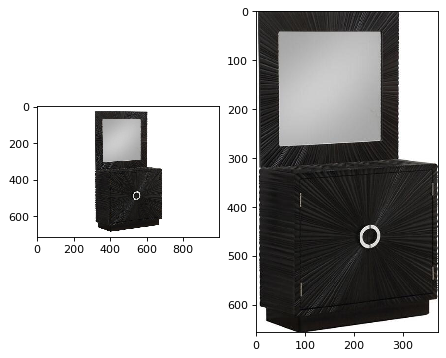

In [15]:
img_name = '18074_1.jpeg'
img_path = img_folder + img_name
demo(img_path, pad = False)

non white pixels percentage: 0.31976744186046513
It is product image with white background


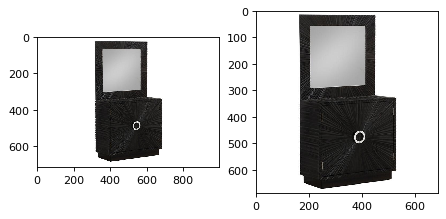

In [16]:
"""
Method: padding(img, marginPercent = 0.05)
Parameters:
1. img - Must be an RGB image
2. marginPercent - How much ratio of white margin comparing to product bounding box's width/height, 5% is a good ratio

Usage:
Pad white pixels around to make an square image if original product image is too high or too thin
"""
def padding(img, marginPercent = 0.05):
    rows, cols, _ = img.shape
    square_length = int(max(rows, cols) * (1 + marginPercent))
    white_img = np.zeros([square_length, square_length,3], dtype=np.uint8)
    white_img.fill(255)
    
    row_gap = int((square_length - rows)/2)
    col_gap = int((square_length - cols)/2)

    white_img[row_gap:(row_gap + rows), col_gap:(col_gap + cols)] = img
    return white_img

img_name = '18074_1.jpeg'
img_path = img_folder + img_name
demo(img_path, pad = True)

non white pixels percentage: 1.0
It is a scene image


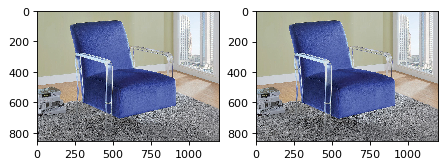

In [17]:
img_name = '18085_1.jpeg'
img_path = img_folder + img_name
img = loadImage(img_path)
demo(img_path)


non white pixels percentage: 1.0
Image Below is Scene Image


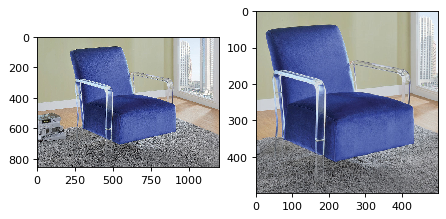

In [18]:
"""
Method: getThumbnail(img)
Parameters:
1. img - Must be an RGB image

Usage:
Generate square thumbmail image from product images / scene images
"""
def getThumbnail(img):
    image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    upper_bound, lower_bound, left_bound, right_bound, isScene = findBound(image_gray)
    new_img = img[upper_bound:lower_bound, left_bound:right_bound]
    nail_img = padding(new_img)
    return_img = nail_img
    if isScene:
        print('Image Below is Scene Image')
        return_img = sceneCrop(new_img)
    else:
        print('Image Below is Product Image with White Background')
    return resize(return_img, (500,500))


"""
Method: sceneCrop(img)
Parameters:
1. img - Must be an RGB image

Usage:
Crop thumbnail square image from scene images
"""
def sceneCrop(img):
    rows, cols, _ = img.shape
    square_length = min(rows, cols) 
    row_gap = abs(int((rows - square_length)/2))
    col_gap = abs(int((cols - square_length)/2))
    return img[row_gap:(rows - row_gap), col_gap:(cols - col_gap), :]

thumb = getThumbnail(img)
f= plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
f.add_subplot(1,3, 1)
plt.imshow(img)

f.add_subplot(1,3, 2)
plt.imshow(thumb)
plt.show()

non white pixels percentage: 0.09980928162746344
Image Below is Product Image with White Background


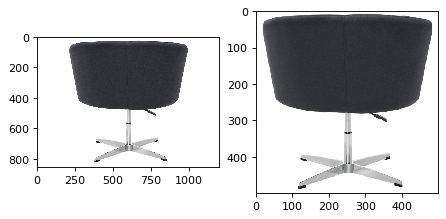

non white pixels percentage: 1.0
Image Below is Scene Image


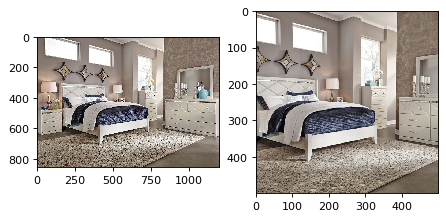

non white pixels percentage: 0.18084260731319554
Image Below is Product Image with White Background


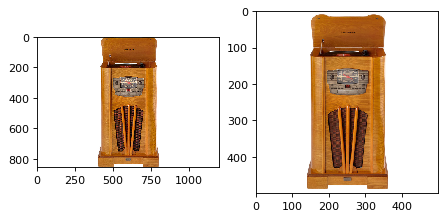

non white pixels percentage: 0.13354763296317942
Image Below is Product Image with White Background


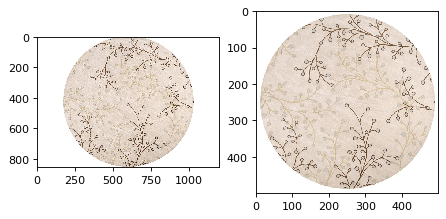

non white pixels percentage: 0.14185110663983905
Image Below is Product Image with White Background


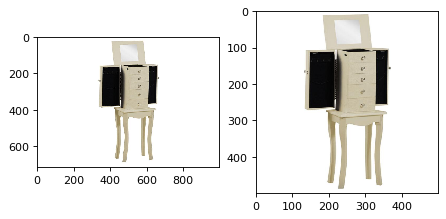

non white pixels percentage: 0.19021190716448033
Image Below is Product Image with White Background


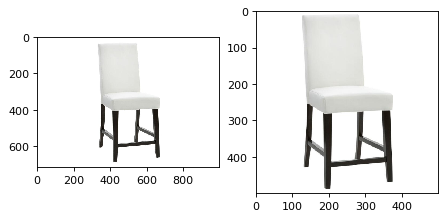

non white pixels percentage: 0.08602941176470588
Image Below is Product Image with White Background


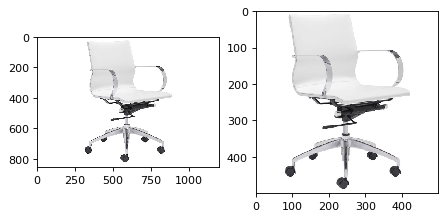

non white pixels percentage: 0.038802660753880266
Image Below is Product Image with White Background


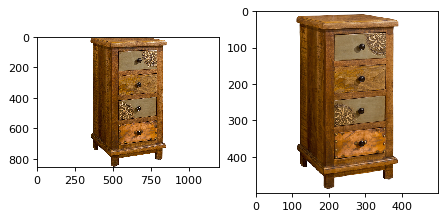

non white pixels percentage: 0.9597197898423818
Image Below is Scene Image


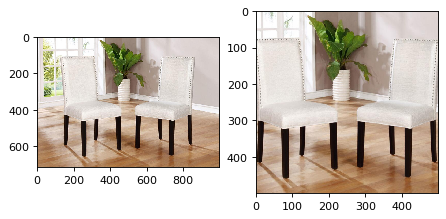

non white pixels percentage: 0.22483621203097082
Image Below is Product Image with White Background


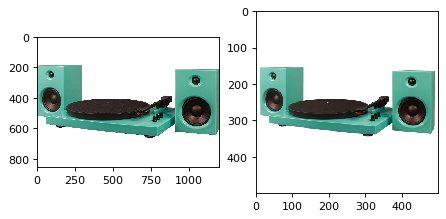

non white pixels percentage: 0.8060335195530727
Image Below is Scene Image


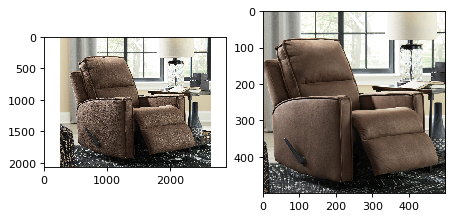

non white pixels percentage: 0.12974868497954412
Image Below is Product Image with White Background


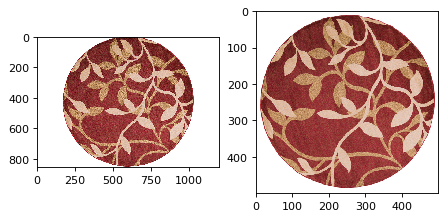

non white pixels percentage: 0.10819327731092437
Image Below is Product Image with White Background


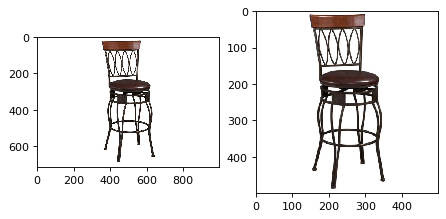

non white pixels percentage: 0.45841121495327103
Image Below is Product Image with White Background


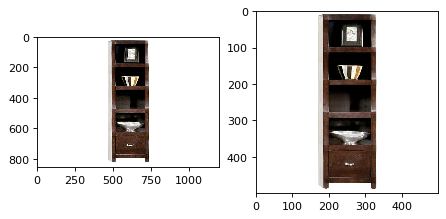

non white pixels percentage: 0.06824925816023739
Image Below is Product Image with White Background


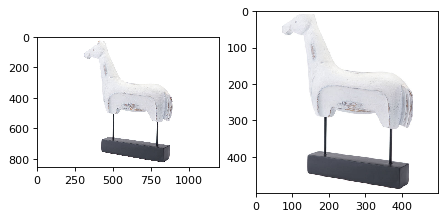

non white pixels percentage: 0.993286631640397
Image Below is Scene Image


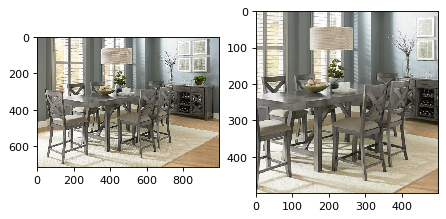

non white pixels percentage: 0.10313174946004319
Image Below is Product Image with White Background


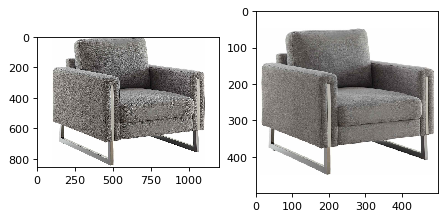

non white pixels percentage: 0.8638794360719494
Image Below is Scene Image


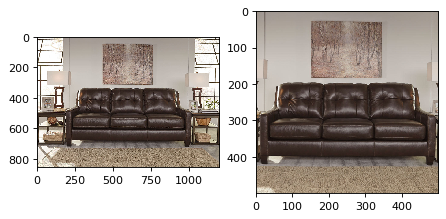

non white pixels percentage: 0.2041595925297114
Image Below is Product Image with White Background


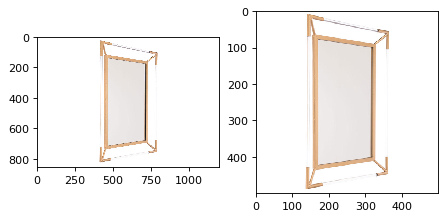

non white pixels percentage: 0.048106060606060604
Image Below is Product Image with White Background


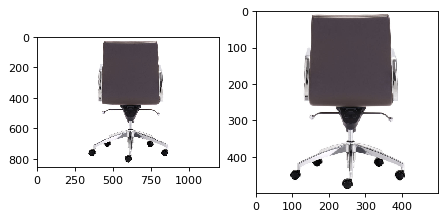

In [19]:

"""
Test and display images. Find all file paths from a folder, the folder should only contain images.
This works better on Jupyter Notebook
Run in terminal would display processed image one by one
"""
image_file_path = '/Users/devin/Desktop/wondersign/Data_Wrangling/TheRoomPlace/images/' # This is a image file folder path.
def test(samples, image_file_path):
    files = os.listdir(image_file_path)
    shuffle(files)
    files = files[0:samples]
    for f in files:
        img = loadImage(image_file_path+f)
        f= plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
        f.add_subplot(1,3, 1)
        plt.imshow(img)
    
        f.add_subplot(1,3, 2)
        thumb = getThumbnail(img)
        plt.imshow(thumb)
        plt.show()
        
test(20, image_file_path)
